# Discrete Bayes Filter

In [2]:
%matplotlib inline

In [3]:
#format the book
import book_format
book_format.set_style()

卡尔曼滤波器属于称为 *贝叶斯滤波器* 的滤波器系列。大多数教科书上对卡尔曼滤波器的处理都提出了贝叶斯公式，也许说明了它是如何影响卡尔曼滤波器方程的，但主要是将讨论保持在非常抽象的层次上。

这种方法需要对数学的几个领域有相当精确的理解，而且它仍然把理解和形成对情况的直观掌握的大部分工作留给了读者。

我将使用不同的方式来展开这个主题，我非常感谢迪特尔·福克斯和塞巴斯蒂安·特伦的工作。它基于一个穿过走廊的物体的例子，建立对贝叶斯统计如何工作的直觉 - 他们使用机器人，我使用狗。我喜欢狗，它们比机器人更难预测，这给滤波带来了有趣的困难。我能找到的第一个发布的例子似乎是 Fox 1999 [1]，在 Fox 2003 [2] 中有一个更完整的例子。 Sebastian Thrun 在他的优达学城机器人人工智能课程 [3] 中也使用了这个公式。事实上，如果您喜欢看视频，我强烈建议您暂停阅读本书，转而阅读该课程的前几节课，然后再回到本书深入探讨该主题。

现在让我们使用一个简单的思想实验，就像我们对 g-h 过滤器所做的一样，看看我们如何推导使用概率进行滤波和跟踪（的过程）。

## Tracking a Dog

让我们从一个简单的问题开始。我们有一个对狗友好的工作区，所以人们带着他们的狗去上班。偶尔，这些狗会从办公室出来，在大厅里闲逛。我们希望能够跟踪它们。因此，在黑客竞赛期间，有人发明了一种声纳传感器来连接到狗的项圈上。它发出信号，监听回声，根据回声返回的速度，我们可以判断狗是否在敞开的门前。它还可以感知狗何时行走，并报告狗移动的方向。它通过 wifi 连接到网络并每秒发送一次更新。

我想跟踪我的狗，西蒙，所以我将设备连接到他的项圈，然后启动 Python，准备编写代码来跟踪他穿过建筑物。乍一看，这似乎是不可能的。如果我开始听 Simon 项圈的感应器，我可能会读到 **door**、**hall**、**hall** 等等。我如何使用这些信息来确定西蒙在哪里？

为了使问题足够小以易于绘制，我们将假设走廊中只有 10 个位置，我们将这些位置编号为 0 到 9，其中 1 位于 0 的右侧。出于稍后会清楚的原因，我们还将假设走廊是圆形或矩形。如果您从位置 9 向右移动，您将位于位置 0。

当我开始听传感器时，我没有理由相信西蒙在走廊的任何特定位置。从我的角度来看，他在任何位置上（0-9）是等可能的。有 10 个位置，所以他在任何给定位置的概率是 1/10。

让我们在 NumPy 数组中代表我们对他的立场的信念。我可以使用 Python 列表，但 NumPy 数组提供了我们很快就会使用的功能。

In [4]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


在 [贝叶斯统计](https://en.wikipedia.org/wiki/Bayesian_probability) 中，这称为 [*prior（先验）*](https://en.wikipedia.org/wiki/Prior_probability)。它是在合并测量或其他信息之前的概率。更完整地说，这称为*先验概率分布*。 [*概率分布*](https://en.wikipedia.org/wiki/Probability_distribution) 是事件所有可能概率的集合。概率分布总和为 1，因为必须发生某些事情；分布列出了所有可能的事件和每个事件的概率。

我相信你以前用过概率——比如“今天下雨的概率是 30%”。上一段听起来更像如此。但贝叶斯统计是概率的一场革命，因为它将概率视为对单个事件的belief（信念）。让我们举个例子。我知道，如果我无限次地掷一枚公平的硬币，我会得到 50% 的正面和 50% 的反面。这称为 [*frequentist statistics*](https://en.wikipedia.org/wiki/Frequentist_inference) 以区别于贝叶斯统计。计算基于事件发生的频率。

我再抛一次硬币，让它落地。我相信它以哪种方式降落？频率论概率对此无话可说。它只会说明 50% 的硬币翻转着陆为正面。在某些方面，为硬币的当前状态分配概率是没有意义的。它要么是正面，要么是反面，我们只是不知道哪个。贝叶斯将此视为对单个事件的信念 - 我的信念或知识的强度，即这次特定的硬币翻转是正面的 50%。有些人反对“belief”这个词；信念可以暗示在没有证据的情况下坚持某事是真实的。在这本书中，它总是衡量我们知识的强度。我们将在前进过程中了解更多相关信息。

贝叶斯统计将过去的信息（先验）考虑在内。我们观察到每 100 天下雨 4 次。由此我可以说明天下雨的几率是 1/25。这不是进行天气预报的方式。如果我知道今天正在下雨并且风暴前沿停滞，那么明天可能会下雨。天气预报是贝叶斯的。

在实践中，统计学家混合使用频率论和贝叶斯技术。有时找到先验是困难的或不可能的，频率论技术占主导地位。在这本书中，我们可以找到先验。当我谈论某事的概率时，我指的是在给定过去事件的情况下某些特定事物为真的概率。当我这样做时，我正在采用贝叶斯方法。

现在让我们创建一张走廊的地图。我们将把前两扇门靠近在一起，然后再把另一扇门放在更远的地方。我们将 1 用于门，0 用于墙壁：

In [5]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

我开始在网络上收听西蒙的传输（的位置信息），我从传感器得到的第一个数据是**门**。 目前假设传感器总是返回正确的答案。 由此我得出结论，他是在一扇门前，但是是哪一扇门？ 我没有理由相信他在第一、第二或第三扇门前。 我能做的就是为每个门分配一个概率。 所有的门都是等概率的，一共有三个，所以我给每个门分配了 1/3 的概率。

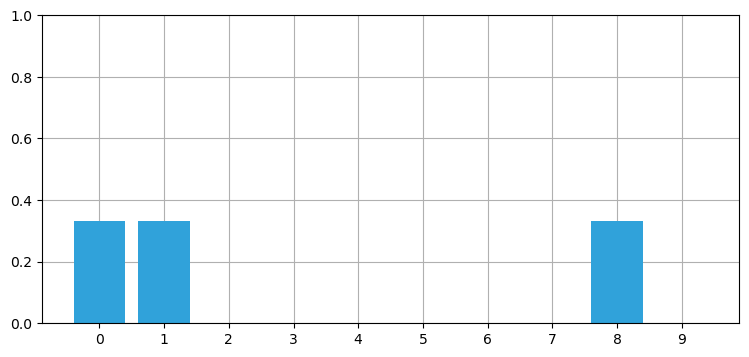

In [6]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

这种分布称为 [*categorical distribution*](https://en.wikipedia.org/wiki/Categorical_distribution)，它是描述观察 $n$ 结果的概率的离散分布。这是一个 [*多峰分布*](https://en.wikipedia.org/wiki/Multimodal_distribution) 因为我们对我们的狗的位置有多种信念。当然，我们并不是说我们认为他同时在三个不同的地点，只是我们将知识范围缩小到这三个地点之一。我的（贝叶斯）信念是，有 33.3% 的机会在 0 号门，33.3% 在 1 号门，33.3% 的机会在 8 号门。

这是两个方面的改进。我已经拒绝了一些走廊位置的可能性，而我对其余位置的信心从 10% 增加到 33%。这将永远发生。随着我们知识的提高，概率将接近 100%。

关于 [*mode*] 的几句话(https://en.wikipedia.org/wiki/Mode_%28statistics%29)
的分布。给定一个数字列表，例如 {1, 2, 2, 2, 3, 3, 4}，*mode* 是最常出现的数字。对于该集合，众数为 2。一个分布可以包含多个众数。列表 {1, 2, 2, 2, 3, 3, 4, 4, 4} 包含模式 2 和 4，因为两者都出现了 3 次。我们说前者是[*unimodal（单峰）*](https://en.wikipedia.org/wiki/Unimodality)，后者是*multimodal（多峰）*。

用于此分布的另一个术语是 [*histogram（直方图）*](https://en.wikipedia.org/wiki/Histogram)。直方图以图形方式描绘了一组数字的分布。上面的条形图是直方图。

我在上面的代码中手动编码了 `belief` 数组。我们将如何在代码中实现这一点？我们用 1 表示门，用 0 表示墙壁，所以我们将走廊变量乘以百分比，就像这样；

In [7]:
belief = hallway * (1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


## Extracting Information from Sensor Readings

让我们把 Python 放在一边，稍微思考一下这个问题。 假设我们要从 Simon 的传感器中读取以下内容：

   * 门
   * 向右移
   * 门
  

我们能推断出西蒙的位置吗？ 当然！ 考虑到走廊的布局，只有一个地方可以得到这个序列，那就是左端。 因此，我们可以自信地说西蒙在第二个门口。 如果这不清楚，假设西蒙是从第二个或第三个门开始的。 向右移动后，他的传感器会返回“墙”。 这与传感器读数不符，所以我们知道他不是从那里开始的。 我们可以对所有剩余的起始位置继续使用该逻辑。 唯一的可能就是，他现在就在第二道门前。 我们的信念是：

In [8]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

我设计了走廊布局和传感器读数，以便快速给我们一个准确的答案。 真正的问题并没有那么明确。 但这应该会触发你的直觉——第一个传感器读数只给我们提供了西蒙位置的低概率 (0.333)，但在位置更新和另一个传感器读数之后，我们对他的位置有了更多的了解。 您可能会正确地怀疑，如果您有一个非常长的走廊和大量的门，经过多次传感器读数和位置更新后，我们是否还能够知道西蒙在哪里，或者（估计的）可能性将缩小到一个很小的数字。 （但是）当一组传感器读数仅匹配一个到几个起始位置时，这是可能的。

我们现在可以实施这个解决方案，但让我们考虑一下这个问题的现实世界的复杂性。

## Noisy Sensors

完美的传感器很少见。 如果西蒙坐在门前抓挠自己，或者如果他没有面向走廊，传感器可能不会检测到门。 因此，当我得到 **door** 时，我不能使用 1/3 作为概率。 我必须为每个门分配小于 1/3 的概率，并为每个空白墙位置分配一个小概率。 就像是

```Python
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```

乍一看，这似乎是不可逾越的。如果传感器有噪音，它就会对每条数据产生怀疑。如果我们总是不确定，我们怎么能得出结论呢？

对于上面的问题，答案是概率。我们已经习惯于为狗的位置分配一个概率信念；现在我们必须考虑由传感器噪声引起的额外不确定性。

假设我们得到 **door** 的读数，并假设测试表明传感器正确的可能性是错误的 3 倍。我们应该在有门的地方将概率分布缩放 3。如果我们这样做，结果将不再是概率分布，但我们稍后将学习如何解决这个问题。（这里我的理解是，传感器出现状态错误报送的概率是25%     ）

让我们看看 Python 代码。在这里，我使用变量 `z` 来表示测量值。 `z` 或 `y` 是文献中用于测量的习惯选择。作为程序员，我更喜欢有意义的变量名，但我希望您能够阅读文献和/或其他滤波代码，因此我现在将开始介绍这些缩写名称。



belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


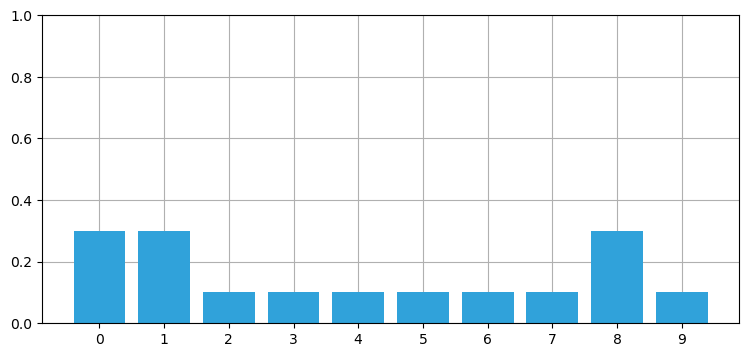

In [9]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

这不是概率分布，因为它的总和不为 1.0。 但代码做的大多是正确的 - 门被分配了一个比墙高 3 倍的数字 (0.3) (0.1)。 我们需要做的就是对结果进行归一化，以便概率之和正确地为 1.0。 标准化是通过将每个元素除以列表中所有元素的总和来完成的。 使用 NumPy 这很容易：

In [10]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

FilterPy 使用 `normalize` 函数实现了这一点：

```Python
from filterpy.discrete_bayes import normalize
normalize(belief)
```

说“正确的可能性是错误的 3 倍”有点奇怪。 我们正在研究概率，所以让我们指定传感器正确的概率，并从中计算比例因子。 方程是

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}}$$


此外，`for` 循环很麻烦。 作为一般规则，您将希望避免在 NumPy 代码中使用 `for` 循环。 NumPy 是用 C 和 Fortran 实现的，所以如果你避免 for 循环，结果的运行速度通常比等效循环快 100 倍。

我们如何摆脱这个 `for` 循环？ NumPy 允许您使用布尔数组索引数组。 您创建一个带有逻辑运算符的布尔数组。 我们可以找到走廊里的所有门：

In [11]:
hallway == 1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

当您使用布尔数组作为另一个数组的索引时，它仅返回索引为“True”的元素。 因此，我们可以将 `for` 循环替换为

```python
belief[hall==z] *= scale
```

并且只有等于 `z` 的元素才会乘以 `scale`。

教你 NumPy 超出了本书的范围。 我将使用惯用的 NumPy 结构并在我第一次展示它们时解释它们。 如果您是 NumPy 的新手，这里有很多关于如何有效和惯用地使用 NumPy 的博客文章和视频。

这是我们改进的版本：


sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


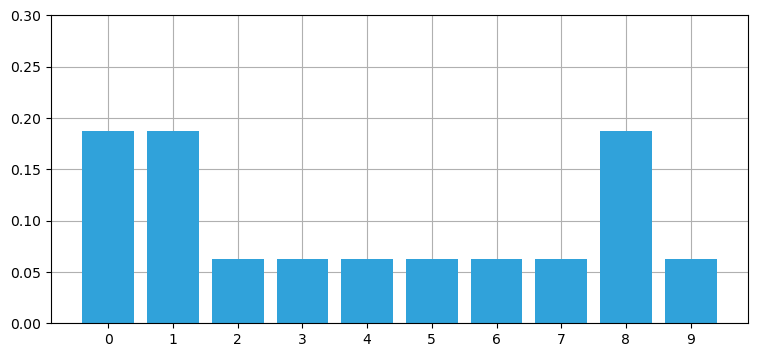

In [12]:
from filterpy.discrete_bayes import normalize

def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

我们可以从输出中看到总和现在是 1.0，门对墙的概率仍然是三倍。结果也符合我们的直觉，门的概率必须小于 0.333，墙的概率必须大于 0.0。最后，它应该符合我们的直觉，我们还没有获得任何信息可以让我们区分任何给定的门或墙壁位置，因此所有门位置都应该具有相同的值，并且墙壁位置也应该如此。（上面这个过程对应于获得第一个传感器的信息是门）
 
这个结果被称为 [*posterior（后验）*](https://en.wikipedia.org/wiki/Posterior_probability)，它是*后验概率分布*的缩写。所有这些意味着是一个纳入测量信息后（ *after* ）的概率分布 （posterior 在这种情况下意味着“之后”）。回顾一下，*prior* 是包括测量信息之前的概率分布。

另一个术语是 [*likelihood（似然）*](https://en.wikipedia.org/wiki/Likelihood_function)。当我们计算 `belief[hall==z] *= scale` 时，我们正在计算每个位置的 *可能* 测量值。似然不是概率分布，因为它的总和不等于 1。（似然进行了对应状态置信更新，但是没有归一化？）

这些的组合给出了等式

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 

当我们谈论滤波器的输出时，我们通常将执行预测后的状态称为 *prior* 或 *prediction*，我们将更新后的状态称为 *posterior* 或 *estimated state*。

学习和内化这些术语非常重要，因为大多数文献都广泛使用它们。

`scaled_update()` 是否执行此计算？ 确实如此。 让我把它改写成这个形式：

In [13]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

这个功能并不完全通用。 它包含有关走廊的知识，以及我们如何将测量与其匹配。 我们总是致力于撰写一个通用函数。 在这里，我们将从函数中删除似然的计算，并要求调用者自己计算似然。

这是算法的完整实现：

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

可能性的计算因问题而异。 例如，传感器可能不会只返回 1 或 0，而是一个介于 0 和 1 之间的“浮点数”，表示在门前的概率。 它可能会使用计算机视觉并当检测到一个斑点形状，然后将概率匹配到一扇门。 它可能会使用声纳并返回距离读数。 在每种情况下，可能性的计算都会不同。 我们将在整本书中看到许多这样的例子，并学习如何执行这些计算。

FilterPy 实现了“更新”。 这是上一个完全通用形式的示例：

In [14]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
print(likelihood)
# 逐点相乘
update(likelihood, belief)  

[3. 3. 1. 1. 1. 1. 1. 1. 3. 1.]


array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

## Incorporating Movement

回想一下，当我们结合一系列测量和运动更新时，我们能够以多快的速度找到准确的解决方案。然而，这发生在一个完美传感器的虚构世界中。我们能否找到带有噪声传感器的精确解决方案？

不幸的是，答案是否定的。即使传感器读数与极其复杂的走廊地图完美匹配，我们也不能 100% 确定狗处于特定位置 - 毕竟，每个传感器读数都有微小的可能性出现错误！当然，在更典型的情况下，大多数传感器读数都是正确的，我们可能接近 100% 确定我们的答案，但永远不会 100% 确定。这可能看起来很复杂，但让我们继续编写数学程序。

首先让我们处理一个简单的情况——假设运动传感器是完美的，它报告狗已经向右移动了一个空间。我们将如何改变我们的“信念”数组？

我希望经过片刻的思考后，我们应该将所有值向右移动一个空间。如果我们之前认为西蒙有 50% 的机会在位置 3，那么在他向右移动一个位置后，我们应该相信他有 50% 的机会在位置 4。走廊是圆形的，所以我们将使用模运算（%）来执行移位。

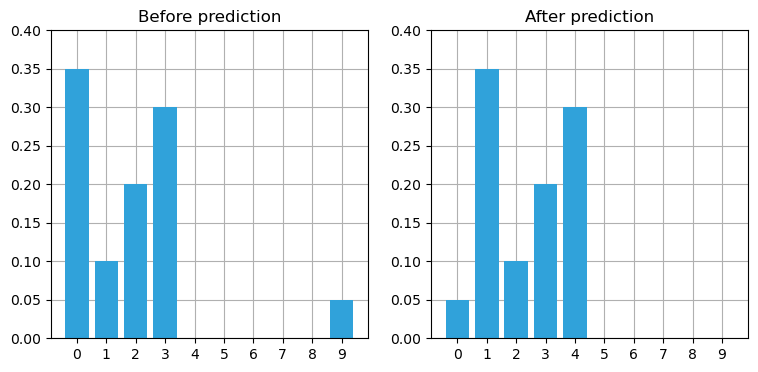

In [15]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
        # print((i-move) % n, i-move)
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

我们可以看到我们正确地将所有值向右移动了一个位置，从数组的末尾换回了开头。

下一个单元格对此进行动画处理，以便您可以看到它的运行情况。 使用滑块在时间上前后移动。 这模拟了西蒙在走廊里走来走去。 它尚未包含新的测量值，因此概率分布不会改变形状，只会改变位置。

In [16]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

## Terminology

让我们停下来回顾一下术语。我在上一章中介绍了这个术语，但让我们花点时间来巩固您的知识。

*system* 是我们试图建模或滤波的。这里的系统是我们的狗。 *state* 是它（system）的当前配置或值。在本章中，状态是我们的狗的位置。我们很少知道实际状态，所以我们说我们的滤波器产生系统的*估计状态*。在实践中，这通常被称为状态，所以要小心理解上下文。
 
使用测量进行预测和更新的一个循环称为状态或系统 ** 演化（evolution）** ，它是 ** 时间演化（time evolution）** 的缩写[7]。另一个术语是 *系统传播（system propagation）* 。它指的是系统状态如何随时间变化。对于滤波器，时间通常是一个离散的步长，例如 1 秒。对于我们的狗追踪器，系统状态是狗的位置，状态演化是经过离散时间后的位置。

我们使用*过程模型*对系统行为进行建模。在这里，我们的过程模型是狗在每个时间步移动一个或多个位置。这不是关于狗行为的特别准确的模型。模型中的误差（error）称为*系统误差*或*过程误差*。

预测是我们新的*先验（prior）*：时间推进下，当在不知道测量结果的情况下做出了预测（对先验的解释）。

让我们举一个例子。 狗的当前位置是 17 m。 我们的epoch是 2 秒，狗以 15 m/s 的速度行进。 我们预测他会在两秒钟内在哪里？
** 注：** 系统传播和测量更新的一次迭代称为*epoch*。（将预测和测量值融合）

清楚地，

$$ \begin{aligned}
\bar x &= 17 + (15*2) \\
&= 47
\end{aligned}$$


我在变量上使用上划线来表示它们是先验（预测）。 我们可以像这样写出过程模型的方程：

$$ \bar x_{k+1} = f_x(\bullet) + x_k$$


$x_k$ 是当前位置或状态。 如果狗在 17 m 处，则 $x_k = 17$。

$f_x(\bullet)$ 是 x 的状态传播函数。 它描述了 $x_k$ 在一个时间步长内的变化程度。 对于我们的示例，它执行计算 $15 \cdot 2$ 因此我们将其定义为

$$f_x(v_x, t) = v_k t$$.

## Adding Uncertainty to the Prediction

`perfect_predict()` 假设测量完美，但所有传感器都有噪声。 如果传感器报告我们的狗移动了一个空格，但它实际上移动了两个空格或零，该怎么办？ 这听起来像是一个无法解决的问题，但让我们对其进行建模，看看会发生什么。

假设传感器的运动测量有 80% 的可能是正确的，有 10% 可能性比当前位置再向右一格（overshoot），有 10% 可能性比当前位置再向左一格（undershoot）。 也就是说，如果移动量度为 4（即向右移动 4 个格），则狗向右移动 4 个格的可能性为 80%，向右移动 3 个格的可能性为 10%，向右移动 5 个格的可能性为 10%。

数组中的每个结果现在都需要包含 3 种不同情况的概率。 例如，考虑收到的移动（信息）是2步（2格）。如果我们 100% 确定狗从位置 3 开始，那么他有 80% 的机会在 5，10% 的机会在 4 或 6。让我们尝试撰写代码：

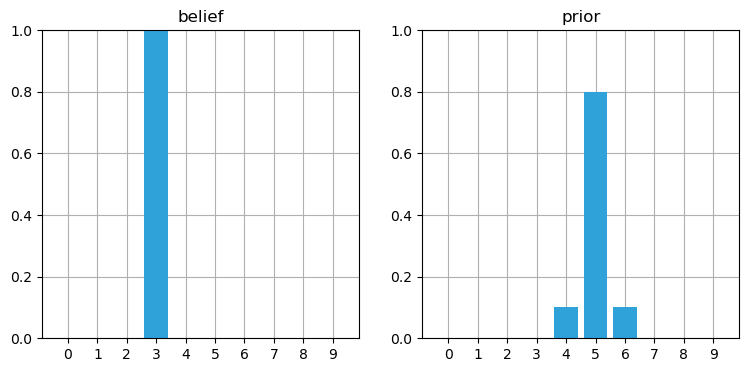

In [17]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    # 对所有先验全部更新
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

它似乎可以正常工作。 现在当我们的信念不是 100% 确定时会发生什么？

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

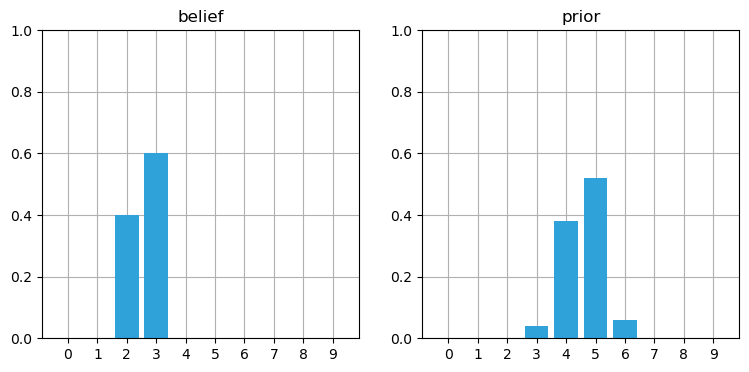

In [18]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

这里的结果更复杂，但您仍然应该能够在头脑中解决它。 0.04 是由于 0.4 置信度低于 1 的可能性（ **注：** 这个0.04源于在开始2位置上，0.4的概率，且由于返回移动的两个步长存在0.1的向左的一个概率 ）。0.38 是由于以下原因：我们移动 2 个头寸 (0.4 $\times$ 0.8) 的可能性为 80%，我们低于 (0.6) 的可能性为 10% $\times$ 0.1）（ **注：** 即源于开始2位置正确移动2步+初始3位置向左移动一格的偏差）。超调（overshoot）在这里没有任何作用，因为如果我们超调 0.4 和 0.6 都会超过这个位置。 **我强烈建议做一些例子，直到所有这些都非常清楚，因为接下来的很多事情都取决于对这一步的理解。**

如果您在执行更新后查看概率，您可能会感到沮丧。在上面的例子中，我们从两个位置的概率 0.4 和 0.6 开始；执行更新后，概率不仅降低，而且散布在整个地图上。

这不是巧合，也不是精心选择的例子的结果——这是真实的预测结果。如果传感器有噪音，我们会在每次预测时丢失一些信息。假设我们要进行无限次预测——结果会是什么？如果我们在每一步都丢失了信息，我们最终将没有一点（有用的）信息，并且我们的概率将在“信念”数组中平均分布。让我们尝试 100 次迭代。情节是动画的；使用滑块更改步骤编号。**

In [19]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step-1])
    plt.title(f'Step {step}')

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [20]:
print('Final Belief:', belief)

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


经过 100 次迭代后，我们几乎丢失了所有信息，尽管我们 100% 确定我们从位置 0 开始。请随意使用数字以查看不同更新次数的效果。 例如，在 100 次更新后只剩下少量信息，在 50 次后还剩下很多，但经过 200 次迭代，基本上所有信息都丢失了。

而且，如果您在线查看此内容，则此处是该输出的动画。
<img src="animations/02_no_info.gif">

我不会在本书的其余部分生成这些独立的动画。 请参阅前言以获取在 Web 上免费运行本书的说明，或在您的计算机上安装 IPython。 这将允许您运行所有单元格并查看动画。 使用此代码练习非常重要，而不仅仅是被动阅读。

## Generalizing with Convolution

我们假设移动误差至多是一个位置。 但误差可能是两个、三个或更多位置。 作为程序员，我们总是希望概括我们的代码，使其适用于所有情况。

这可以通过 [*convolution*](https://en.wikipedia.org/wiki/Convolution) 轻松解决。 卷积用另一个函数修改一个函数。 在我们的例子中，我们正在用传感器的误差函数修改概率分布。 `predict_move()` 的实现是一个卷积，虽然我们没有这样称呼它。 形式上，卷积定义为

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

其中 $f\ast g$ 是 f 乘 g 的卷积符号。 这并不意味着乘法。

积分适用于连续函数，但我们使用的是离散函数。 我们用求和代替积分，用数组括号代替括号。（f是卷积核核函数）

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

比较表明`predict_move()` 正在计算这个方程——它计算一系列乘法的总和。

[可汗学院](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution) [4] 对卷积有很好的介绍，和 维基百科有一些优秀的卷积动画[5]。 但是大体思路已经很清楚了。 您将一个名为 *kernel* 的数组滑过另一个数组，将当前单元格的邻居与第二个数组的值相乘。 在上面的示例中，我们使用 0.8 表示移动到正确位置的概率，0.1 表示下冲（undershoot），0.1 表示过冲（overshoot）。 我们用数组 `[0.1, 0.8, 0.1]` 制作了一个内核（卷积核）。 我们需要做的就是编写一个循环，遍历数组的每个元素，乘以内核，然后对结果求和。 为了强调信念（belief）是一种概率分布，我将其命名为“pdf”。

In [30]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)
    # print("width:", width)
    prior = np.zeros(N)
    for i in range(N):
        print("--------------------------------------------------")
        for k in range (kN):
            index = (i + (width - k) - offset) % N
            # print(i, index, k)
            prior[i] += pdf[index] * kernel[k]
    return prior

这说明了算法，但它运行得非常慢。 SciPy 在 `ndimage.filters` 模块中提供了一个卷积例程 `convolve()`。 我们需要在卷积之前将 pdf 偏移 `offset`； `np.roll()` 就是这样做的。 移动和预测算法可以用一行来实现：

```python
convolve(np.roll(pdf, offset), kernel, mode='wrap')
```

FilterPy 使用 `discrete_bayes`'`predict()` 函数实现了这一点。

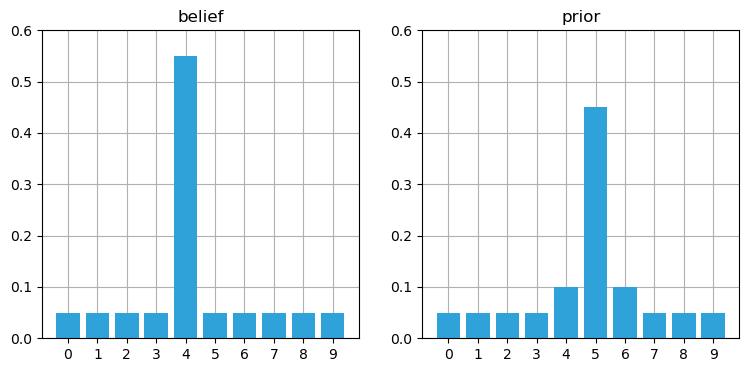

In [32]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
# prior = predict_move_convolution(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

除了中间的元素外，所有元素都没有改变。 位置 4 和 6 中的值应为
$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$

位置 5 应该是 $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$

让我们确保它为大于 1 的运动和非对称内核正确移动位置。

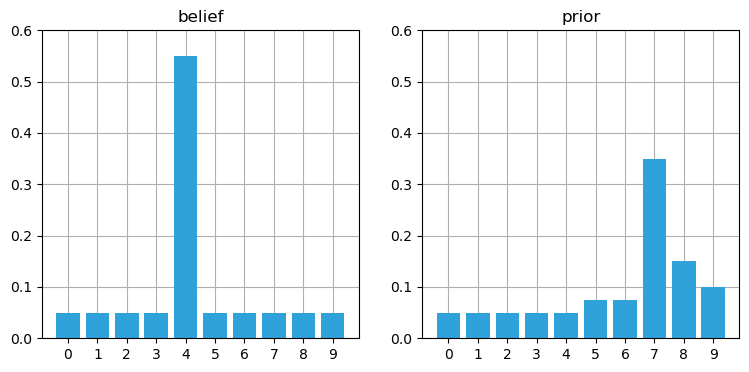

In [21]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

这个位置被正确地移动了3个位置，我们赋予了undershoot和overshoot的可能性更多的权重，因此这看起来是正确的。
确保你已经理解我们做的事情。我们正在预测小狗的移动位置，并对（信念）概率分布进行了卷积操作以获得先验信息。

如果我们没有使用概率，那么我们会使用之前所给出的等式：
$$ \bar x_{k+1} = f_x(\bullet) + x_k$$

在先验中，我们预测狗小狗将在哪里，为小狗移动的距离加上它当前的位置。当小狗在（位置）10处，它移动了5米，因此他在15米处。这是很简单的事情。但是当我们使用概率模型到此处时，我们的方程为：
$$ \bar x_{k+1} = x_k \ast f_x(\bullet) $$

我们将  当前的概率位置估计值（ *the current probabilistic position estimate*  ）  与我们认为的  狗移动了多少的概率估计值（ *a probabilistic estimate of how much we think the dog moved*  ）  进行卷积，这是同一个概念，但是数学上略有不同，粗体x定义了一个数字数组。


## Integrating Measurements and Movement Updates

在预测过程中丢失信息的问题可能会让我们的系统看起来好像很快就会变成一无所知。但是，每次预测之后都会进行更新，即我们将测量结果合并到估计值中。更新提高了我们的知识。更新步骤的输出被输入到下一个预测中。预测降低了我们的确定性。这被传递到另一个更新（这个确定性在测量信息增加后进行提高），其中确定性再次增加。

让我们直观地思考一下。考虑一个简单的案例 - 您正在跟踪一只坐着不动的狗。在每次预测期间，您都预测他不会移动。你的滤波器很快*收敛*他的位置的准确估计。然后厨房里的微波炉打开了，他像一道闪电般奔去。你不知道这一点，所以在下一个预测中你预测他在同一个位置。但测量结果讲述了一个不同的故事。当您合并测量值时，您的信念将沿着走廊分散，通向厨房。在每个时期（循环）中，您认为他坐着不动的信念会变小，而您认为他以惊人的速度进入厨房的信念会增加。

这就是直觉告诉我们的。数学告诉我们什么？

我们已经对更新和预测步骤进行了编程。我们需要做的就是将一个的结果输入另一个，我们将实现一个狗追踪器！！！让我们看看它的表现如何。我们将输入测量值，就好像狗从位置 0 开始并在每个时期向右移动一个位置。就像在现实世界的应用程序中一样，我们将从不知道他的位置开始，为所有位置分配相等的概率。

[3. 3. 1. 1. 1. 1. 1. 1. 3. 1.]


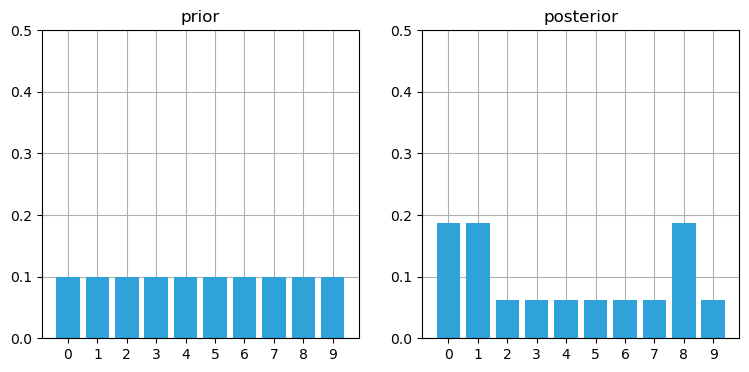

In [49]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
print(likelihood)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

第一次更新后，我们为每个门位置分配了高概率，为每个墙位置分配了低概率。

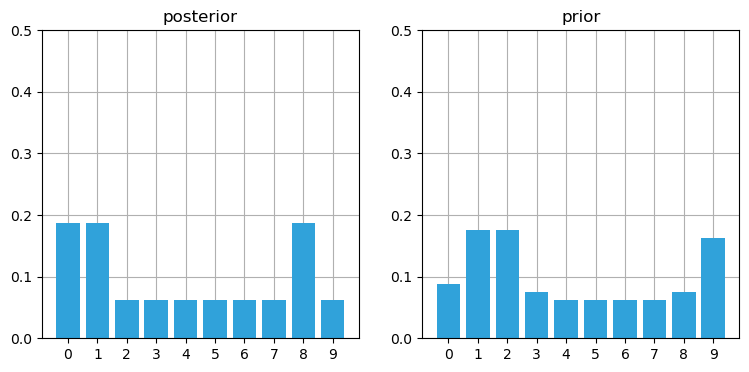

In [50]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

预测步骤将这些概率向右移动，使它们模糊了一点。 现在让我们看看在下一个意义上会发生什么。

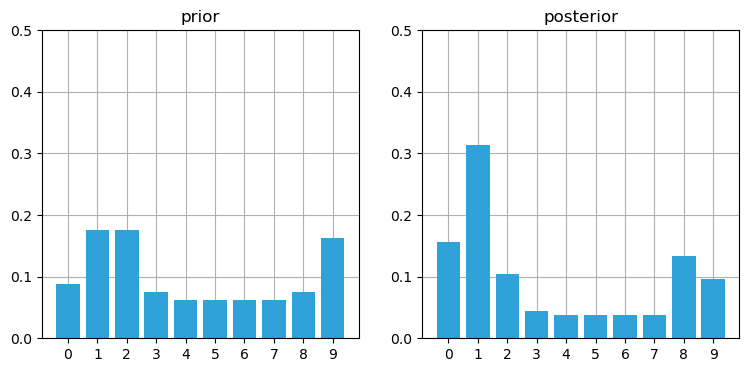

In [51]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

注意位置 1 处的高条。这对应于从位置 0 开始、感应一扇门、向右移动 1 并感应另一扇门的（正确）情况。 没有其他职位可以使这组观察结果如此有可能。 现在我们将添加一个更新，然后感知墙壁。

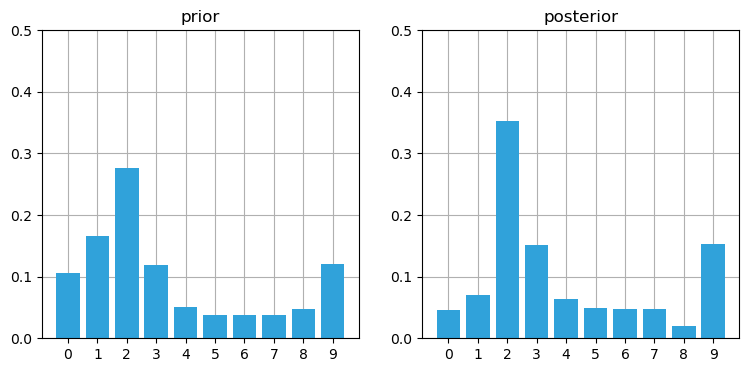

In [52]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

这真让人兴奋！ 我们在位置 2 有一个非常突出的条形，其值约为 35%。 它是图中任何其他条形值的两倍多，比我们上一个图中的最高条形大约 31% 大约 4%。 让我们再看一个循环。

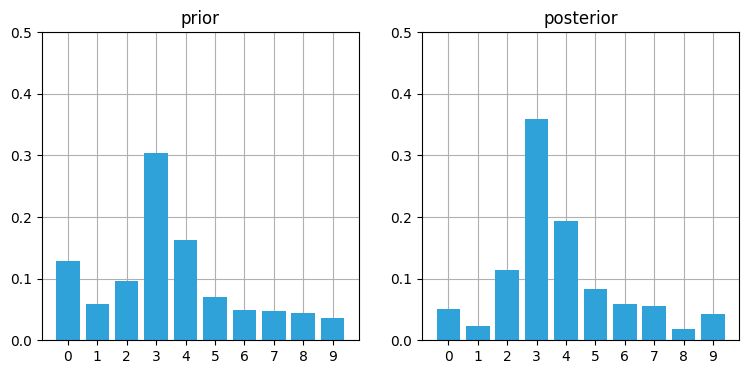

In [28]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

我忽略了一个重要的问题。 早些时候我假设我们有一个用于预测步骤的运动传感器； 然后，当谈到狗和微波炉时，我假设你不知道他突然开始奔跑。 我提到过你对狗正在奔跑的信念会随着时间的推移而增加，但我没有为此提供任何代码。 简而言之，如果我们不直接测量它，我们如何检测和/或估计过程模型中的变化？

现在我想忽略这个问题。 在后面的章节中，我们将学习这种估计背后的数学原理； 现在，仅仅学习这个算法就已经是一个足够大的任务了。 解决这个问题非常重要，但我们还没有构建足够的数学设备，因此在本章的其余部分，我们将假设我们有一个可以感知运动的传感器来忽略这个问题。

## 离散贝叶斯算法

该图表说明了该算法：

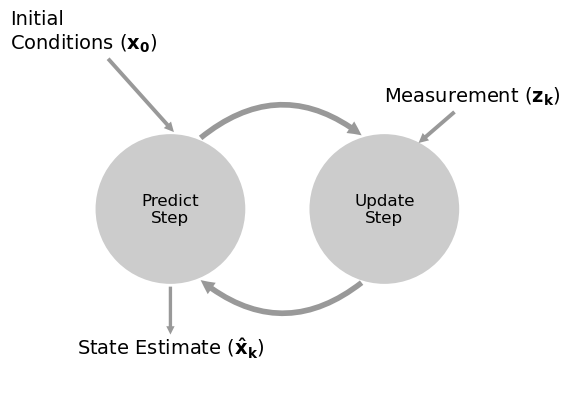

In [53]:
book_plots.predict_update_chart()

此过滤器是 g-h 滤波器的一种形式。 这里我们使用误差的百分比来隐式计算 $g$ 和 $h$ 参数。 我们可以将离散贝叶斯算法表示为 g-h 过滤波器，但这会掩盖该滤波器的逻辑。

滤波器方程为：

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$


$\mathcal L$ 是编写似然函数的常用方法，所以我使用它。 $\|\|$ 符号表示取范数。 我们需要将似然与先验的乘积归一化，以确保 $x$ 是一个总和为 1 的概率分布。

我们可以用伪代码来表达。

**初始化**

     1. 初始化我们对状态的信念
    
**预测**

     1.根据系统行为，预测下一时间步的状态
     2. 调整信念以解释预测的不确定性
    
**更新**

     1. 获得关于其准确性的测量和相关信念
     2. 计算测量与每个状态匹配的可能性
     3. 用这种可能性更新状态信念
     
当我们介绍卡尔曼滤波器时，我们将使用完全相同的算法； 只有计算的细节会有所不同。

这种形式的算法有时称为*预测器校正器（predictor correctors）*。 我们做出预测，然后纠正它们。

让我们执行一下（这个过程）。 首先让我们编写函数来执行滤波并在任何步骤绘制结果。 我用黑色标出了门口的位置。 先验用橙色绘制，后验用蓝色绘制。 我画了一条粗垂直线来指示西蒙的真实位置。 这不是滤波器的输出——我们知道西蒙在哪里只是因为我们正在模拟他的运动。

In [54]:
# 离散贝叶斯仿真函数
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(hallway, posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)    
    
def plot_prior(hallway, priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)    

def animate_discrete_bayes(hallway, priors, posteriors):
    def animate(step):
        step -= 1
        i = step // 2    
        if step % 2 == 0:
            plot_prior(hallway, priors, i)
        else:
            plot_posterior(hallway, posteriors, i)
    
    return animate

让我们运行滤波器并为其设置动画。

In [67]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# measurements with no noise  进行了5个循环
zs = [hallway[i % len(hallway)] for i in range(50)]
print(len(zs))

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
# print(len(priors))
# print(posteriors)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=1, max=len(zs)*2));
# 橙色先验 蓝色后验 ，粗线是真实位置

50
[array([0.333, 0.333, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.333,
       0.   ]), array([0.167, 0.75 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.083,
       0.   ]), array([0.   , 0.   , 0.813, 0.099, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.088]), array([0.   , 0.   , 0.088, 0.717, 0.174, 0.011, 0.   , 0.   , 0.   ,
       0.01 ]), array([0.   , 0.   , 0.009, 0.144, 0.605, 0.214, 0.026, 0.001, 0.   ,
       0.001]), array([0.   , 0.   , 0.001, 0.022, 0.177, 0.522, 0.235, 0.043, 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.003, 0.037, 0.208, 0.487, 0.26 , 0.   ,
       0.005]), array([0.   , 0.   , 0.   , 0.001, 0.008, 0.069, 0.296, 0.59 , 0.   ,
       0.036]), array([0.054, 0.007, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.94 ,
       0.   ]), array([0.   , 0.   , 0.014, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.985]), array([0.889, 0.111, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.11, 0.89, 0.  , 0.  , 0.  , 0.  , 0.  , 0

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

现在我们可以看到结果了。 您可以看到先验如何移动位置并降低确定性，而后验保持在相同位置并增加确定性，因为它结合了测量信息。 我用`z_prob = 1.0`行使测量变得完美； 我们将在下一节探讨不完美测量的影响。 最后，

另一件需要注意的事情是，当我们在门前时，我们的估计会变得多么准确，而在走廊中间时，它会如何降级。 这应该具有直观意义。 只有几个门口，所以当传感器告诉我们我们在门前时，这会增强我们对自己位置的确定性。 长时间没有门会降低我们的确定性。

## The Effect of Bad Sensor Data

您可能对上述结果表示怀疑，因为我总是将正确的传感器数据传递给函数。 但是，我们声称此代码实现了 *filter* - 它应该过滤掉不良的传感器测量值。 它这样做吗？

为了便于编程和可视化，我将走廊的布局更改为主要是交替的门和走廊，并在 6 次正确测量上运行算法：

In [68]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=12, max=len(zs)*2));

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

我们已经确定了从位置 0 或 5 开始的可能情况，因为我们看到了门和墙的以下序列：1,0,1,0,0。 现在我注入了一个错误的测量值。 下一个测量值应该是 0，但我们得到的是 1：

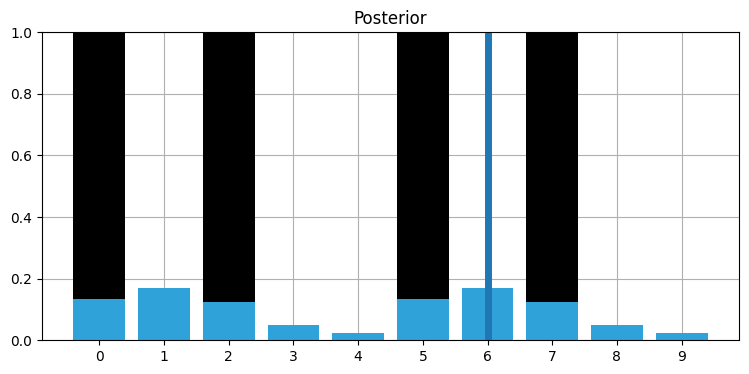

In [33]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway);
plot_posterior(hallway, posteriors, 6)

这种糟糕的衡量标准已经大大侵蚀了我们的知识。 现在让我们继续进行一系列正确的测量。

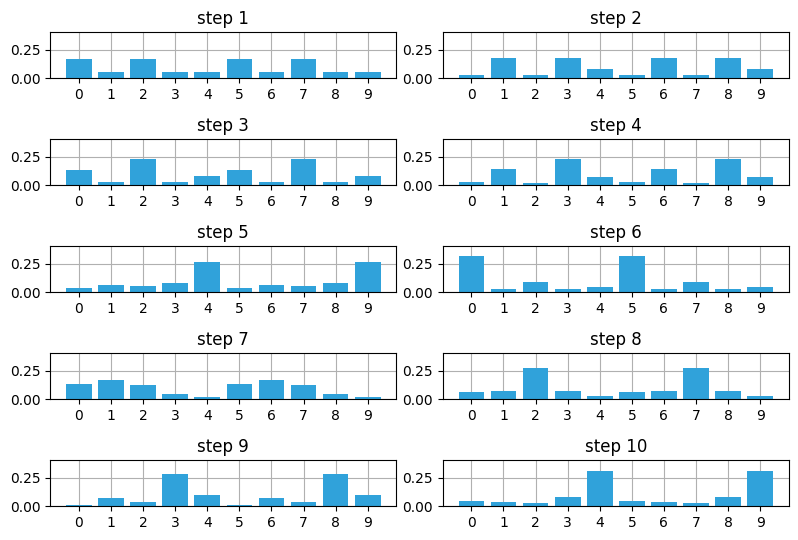

In [34]:
with figsize(y=5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title=f'step {i+1}')
    plt.tight_layout()

我们很快过滤掉了错误的传感器读数，并集中在我们的狗最可能的位置上。

## Drawbacks and Limitations


不要被我选择的例子的简单性所误导。这是一个强大而完整的滤波器，您可以在现实世界的解决方案中使用该代码。如果您需要多模态离散滤波器，则此滤波器有效。

话虽如此，这个滤波器并不经常使用，因为它有几个限制。绕过这些限制是本书其余章节背后的动机。

第一个问题是缩放。我们的狗跟踪问题仅使用一个变量 $pos$ 来表示狗的位置。大多数有趣的问题都希望在一个大空间中跟踪几件事情（多维变量）。实际上，至少我们希望跟踪我们的狗的 $(x,y)$ 坐标，可能还有他的速度 $(\dot{x},\dot{y})$。我们没有涵盖多维情况，但我们使用多维网格代替数组来存储每个离散位置的概率。每个 `update()` 和 `predict()` 步骤都需要更新网格中的所有值，因此一个简单的四变量问题将需要 $O(n^4)$ 运行时间*每个时间步*。现实滤波器可以跟踪 10 个或更多变量，从而导致过高的计算要求。

第二个问题是滤波器是离散的，但我们生活在一个连续的世界中。直方图要求您将滤波器的输出建模为一组离散点。一条 100 米长的走廊需要 10,000 个位置才能将走廊建模到 1 厘米的精度。因此，每次更新和预测操作都需要对 10,000 个不同的概率进行计算。随着我们添加维度，情况会呈指数级恶化。一个 100x100 m$^2$ 的庭院需要 100,000,000 个bins才能获得 1 厘米的精度。

第三个问题是过滤器是多模态的。在最后一个例子中，我们最终坚信狗在位置 4 或 9。这并不总是一个问题。我们将在后面研究的粒子滤波器是多模态的，并且由于这个特性而经常被使用。但是想象一下，如果您汽车中的 GPS 向您报告，40% 的确定您在 D 街，30% 确定您在 Willow Avenue。

第四个问题是它需要测量状态的变化。我们需要一个运动传感器来检测狗的移动量。有一些方法可以解决这个问题，但这会使本章的阐述变得复杂，因此，鉴于上述问题，我将不再进一步讨论。

话虽如此，如果我有这个技术可以处理的小问题，我会选择使用它；实现、调试和理解所有优点是微不足道的。

## Tracking and Control

我们一直在被动地跟踪一个自主移动的物体。但是考虑一下这个非常相似的问题。我正在自动化仓库并希望使用机器人来收集客户订单的所有物品。也许最简单的方法是让机器人在火车轨道上行驶。我希望能够向机器人发送目的地并将其送到那里。但是火车轨道和机器人马达并不完美。车轮打滑和不完善的电机意味着机器人不太可能准确地移动到您命令的位置。有不止一个机器人，我们需要知道它们都在哪里，以免导致它们坠毁。

所以我们添加了传感器。也许我们每隔几英尺就在轨道上安装磁铁，并使用霍尔传感器来计算通过了多少磁铁。如果我们数到 10 个磁铁，那么机器人应该在第 10 个磁铁处。当然，有可能遗漏磁铁或计数两次，因此我们必须适应一定程度的误差。我们可以使用上一节中的代码来跟踪我们的机器人，因为磁铁计数与门口感应非常相似。

但我们还没有完成。我们已经学会了永远不要丢弃信息。如果你有信息，你应该用它来改进你的估计。我们遗漏了哪些信息？我们知道我们在每个时刻向机器人的轮子提供哪些控制输入。例如，假设我们每秒向机器人发送一次运动命令 - 向左移动 1 个单位，向右移动 1 个单位，或静止不动。如果我发送命令“向左移动 1 个单位”，我预计从现在开始的一秒钟内，机器人将在现在所在位置的左侧 1 个单位。这是一种简化，因为我没有考虑加速度，但我不是在尝试教授控制理论。车轮和电机不完善。机器人最终可能会在 0.9 个单位之外，或者可能在 1.2 个单位之外。

现在整个解决方案很清楚了。我们假设狗一直朝他之前移动的任何方向移动。这对我的狗来说是一个可疑的假设！机器人的可预测性要高得多。我们将输入我们发送给机器人的命令，而不是基于行为假设做出可疑的预测！换句话说，当我们调用“predict()”时，我们将传递给机器人的命令运动以及描述该运动可能性的内核。

### Simulating the Train Behavior

我们需要模拟一个不完美的火车。 当我们命令它移动时，它有时会犯一个小错误，它的传感器有时会返回不正确的值。

In [69]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

有了这个，我们就可以编写滤波器了。 我们将把它放在一个函数中，以便我们可以在不同的假设下运行它。 我会假设机器人总是从赛道的起点开始。 轨道被实现为 10 个单位长，但可以将其视为一个长度为 10,000 的轨道，磁铁图案每 10 个单位重复一次。 长度为 10 可以更轻松地绘制和检查。

In [70]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    posterior = prior[:]
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # move the robot and
        robot.move(distance=move_distance)

        # peform prediction
        prior = predict(posterior, move_distance, kernel)       

        #  and update the filter 带随机误差的环境值，测量
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)  # 最大似然估计

        if do_print:
            print(f'time {i}: pos {robot.pos}, sensed {m}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'        estimated position is {index} with confidence {conf:.4f}%:')            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        print('''Estimated position is {} with '''
              '''confidence {:.4f}%:'''.format(
                index, posterior[index]*100))

阅读代码并确保您理解它。 现在让我们在没有传感器或移动错误的情况下运行。 如果代码正确，它应该能够准确无误地定位机器人。 输出阅读起来有点乏味，但如果您完全不确定更新/预测周期的工作方式，请确保仔细阅读以巩固您的理解。

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 99.9900%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 100.0000%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 100.0000%:

final position is 6
Estimated position is 6 with confidence 100.0000%:


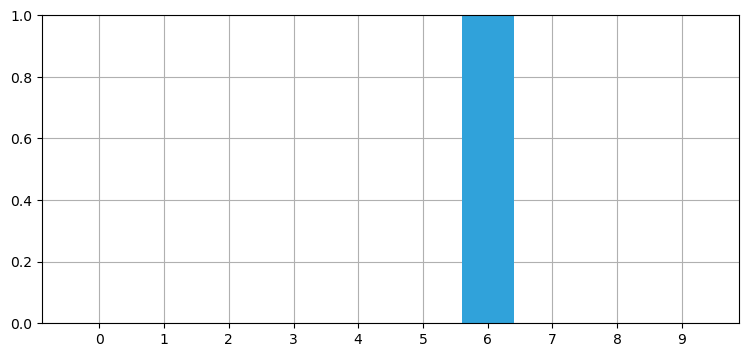

In [71]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

我们可以看到代码能够完美地跟踪机器人，所以我们应该有理由相信代码正在工作。 现在让我们看看它如何处理一些错误。

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 96.0390%:
time 1: pos 8, sensed 9, at position 8
        estimated position is 9 with confidence 52.1180%:
time 2: pos 3, sensed 3, at position 3
        estimated position is 3 with confidence 88.3993%:
time 3: pos 7, sensed 8, at position 7
        estimated position is 8 with confidence 49.3174%:

final position is 7
Estimated position is 8 with confidence 49.3174%:


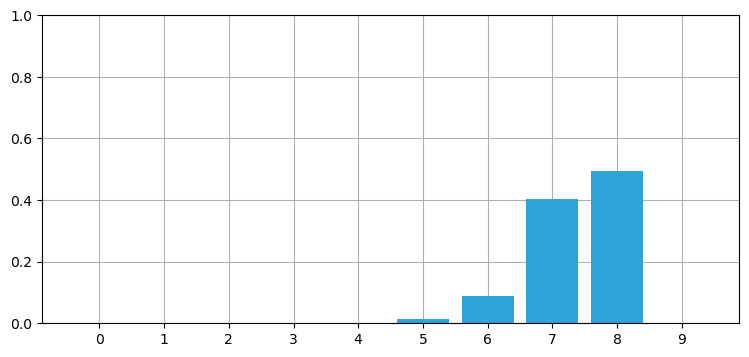

In [72]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

在时间 1 有一个感应错误，但我们仍然对我们的位置很有信心。

现在让我们运行一个很长的模拟，看看滤波器如何响应错误。

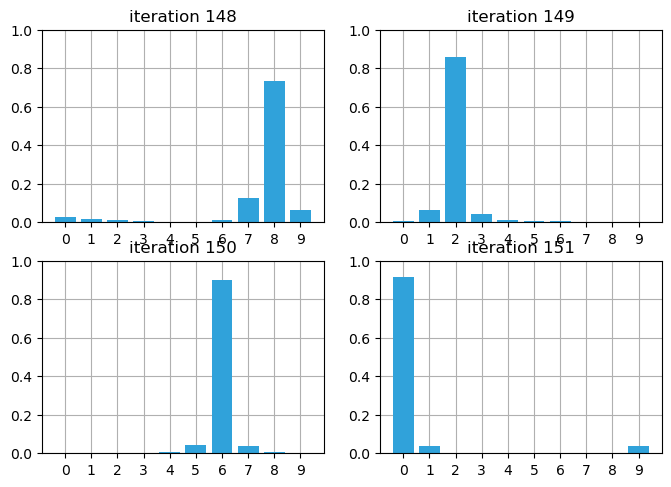

In [74]:
with figsize(y=5.5):
    for i in range (4):
        random.seed(3)
        plt.subplot(221+i)
        train_filter(148+i, kernel=[.1, .8, .1], 
                     sensor_accuracy=.8,
                     move_distance=4, do_print=False)
        plt.title (f'iteration {148 + i}')

我们可以看到，随着置信度的降低，第 149 次迭代出现了问题。 但是在几次迭代中，滤波器能够自我纠正并重新获得对估计位置的信心。

## Bayes Theorem and the Total Probability Theorem

我们仅仅通过推理我们在每一时刻所拥有的信息来发展本章中的数学。在这个过程中，我们发现了 [*Bayes' Theorem*](https://en.wikipedia.org/wiki/Bayes%27_theorem) 和 [*Total Probability Theorem*](https://en.wikipedia.org/wiki /Law_of_total_probability）。

贝叶斯定理告诉我们如何计算给定先前信息的事件的概率。

我们用这个概率计算实现了 `update()` 函数：

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization\, factor}}$$

我们还没有开发数学来讨论贝叶斯，但这是贝叶斯定理。本书中的每个滤波器都是贝叶斯定理的表达。在下一章中，我们将发展数学，但在许多方面会掩盖这个等式表达的简单思想：

$$ 更新\,知识 = \big\|likelihood\,of\,new\,knowledge\times prior\, Knowledge \big\|$$

$\| \cdot\|$ 表示将术语标准化。

我们通过简单的推理得出了这一点，即一只狗在走廊上行走。然而，正如我们将看到的，同样的方程适用于一系列过滤问题。我们将在随后的每一章中使用这个等式。

同样，“predict()”步骤计算多个可能事件的总概率。这在统计学中被称为*总概率定理*，在开发了一些辅助数学之后，我们还将在下一章中介绍它。

现在，我需要您了解贝叶斯定理是将新信息合并到现有信息中的公式。

## Summary


代码很短，但结果令人印象深刻！我们已经实现了一种形式的贝叶斯过滤器。我们已经学会了如何从无信息开始，并从嘈杂的传感器中获取信息。尽管本章中的传感器非常嘈杂（例如，大多数传感器的准确率超过 80%），但我们仍能迅速收敛到我们的狗最可能的位置。我们已经了解了预测步骤如何总是降低我们的知识，但是添加另一个测量，即使它可能有噪音，也会提高我们的知识，使我们能够收敛到最可能的结果。

这本书主要是关于卡尔曼滤波器。它使用的数学方法不同，但逻辑与本章使用的完全相同。它使用贝叶斯推理从测量和过程模型的组合中形成估计。

**如果你能理解本章，你将能够理解和实现卡尔曼滤波器。**我怎么强调这一点都不为过。如果有任何不清楚的地方，请返回并重新阅读本章并使用代码。本书的其余部分将建立在我们在这里使用的算法之上。如果您不理解此过滤器的工作原理，您将无法在其余材料上取得成功。但是，如果您掌握了基本的见解——在我们测量时乘以概率，并在我们更新时改变概率导致收敛解决方案——那么在学习了一些数学之后，您就可以准备实施卡尔曼滤波器了。


## References

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 
 * [4] Khan Acadamy. "Introduction to the Convolution"
 
 https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution
 
 
* [5] Wikipedia. "Convolution"

 http://en.wikipedia.org/wiki/Convolution

* [6] Wikipedia. "Law of total probability"

  http://en.wikipedia.org/wiki/Law_of_total_probability
  
* [7] Wikipedia. "Time Evolution"

 https://en.wikipedia.org/wiki/Time_evolution
 
* [8] We need to rethink how we teach statistics from the ground up
 
 http://www.statslife.org.uk/opinion/2405-we-need-to-rethink-how-we-teach-statistics-from-the-ground-up